In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from collections import Counter
versions = {
    "OpenCV":cv2.__version__,
    "NumPy":np.__version__,
    "Matplotlib": matplotlib.__version__,
    "PIL": Image.__version__,
    "collections":"built-in"
}
versions # Note: This program may not perform at the same level when using different versions of packages

{'OpenCV': '4.8.1',
 'NumPy': '1.24.3',
 'Matplotlib': '3.8.0',
 'PIL': '10.0.1',
 'collections': 'built-in'}

# Part 1

## Image cutting

In [2]:
# Define path and open the first image
reg_path = "Assignment/data/RESISTORS/"
img_path = reg_path+'RESISTORS-1.png'
img = Image.open(img_path)

In [3]:
# Define a function to separate each resistor
def separate_resistors(image):
    width, height = image.size
    pixels = image.load()
    gap_threshold = height * 0.9
    white_threshold = 250  
    gap_indices = []
    for x in range(width):
        white_count = sum(1 for y in range(height) if pixels[x, y] >= (white_threshold, white_threshold, white_threshold))
        if white_count > gap_threshold:
            gap_indices.append(x)
    resistor_bounds = []
    start_x = 0
    for gap_x in gap_indices:
        end_x = gap_x
        if end_x - start_x > 1:  
            resistor_bounds.append((start_x, 0, end_x, height))
        start_x = gap_x + 1
    if start_x < width:
        resistor_bounds.append((start_x, 0, width, height))
    resistor_images = [image.crop(bounds) for bounds in resistor_bounds]
    return resistor_images

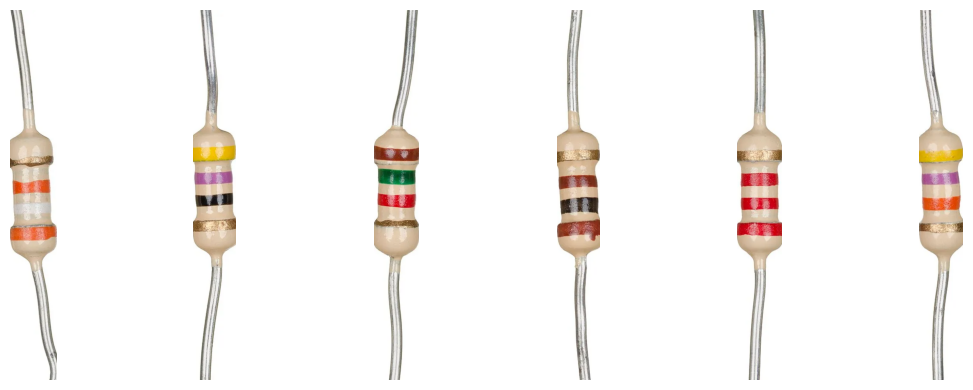

In [4]:
resistor_imgs = separate_resistors(img)
# Save separated resistor photos
separated_img_paths = []
for i, resistor_img in enumerate(resistor_imgs):
    path = f'resistor_{i}.png'
    resistor_img.save(path)
    separated_img_paths.append(path)
separated_img_paths

# Display them
fig, axes = plt.subplots(nrows=1, ncols=len(separated_img_paths), figsize=(12, 4))
for ax, img_path in zip(axes, separated_img_paths):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off') 
plt.tight_layout() 
plt.show()

In [5]:
def remove_resistor_backgroud(image_path, output_path):
    image = Image.open(image_path)
    # Convert to RGBA
    image = image.convert('RGBA')
    # Convert the image to numpy array
    data = np.array(image)
    white_threshold = 240
    # Create a mask where white is set to True and the rest to False
    white_areas = (data[:,:,0] > white_threshold) \
                  & (data[:,:,1] > white_threshold) \
                  & (data[:,:,2] > white_threshold)
    # Set the alpha channel to 0 for all white areas (making them transparent)
    data[white_areas, -1] = 0
    # Convert the numpy array back to an image
    image_no_white = Image.fromarray(data)
    # Save the image without white background
    image_no_white.save(output_path)

In [6]:
for i in range(len(resistor_imgs)):
    image_path = f'resistor_{i}.png'
    output_path = f'RESISTORS_{i}_no_white.png'
    remove_resistor_backgroud(image_path, output_path)

In [7]:
def transparent_to_pink(input_path, output_path, fill_color=(255, 255, 255)):
    image = Image.open(input_path)
    width, height = image.size

    rows_to_keep = []

    for y in range(height):
        row = [image.getpixel((x, y)) for x in range(width)]  
        new_row = []

        for pixel in row:
            if pixel[3] >= (255 / 2):
                new_row.append(pixel[:3]) 
            else:
                new_row.append(fill_color) 

        if any(pixel[3] >= (255 / 2) for pixel in row):
            rows_to_keep.append(new_row)

    new_height = len(rows_to_keep)
    new_image = Image.new('RGB', (width, new_height))

    for y, row in enumerate(rows_to_keep):
        for x, pixel in enumerate(row):
            new_image.putpixel((x, y), pixel)

    new_image.save(output_path, 'JPEG')

In [8]:
def remove_wire(input_path, output_path, target_color=(255, 192, 203), threshold=0.5):
    # Load the original image
    image = Image.open(input_path)
    width, height = image.size

    # Initialize a list to store rows to keep
    rows_to_keep = []

    # Process image horizontally
    for y in range(height):
        row = [image.getpixel((x, y)) for x in range(width)]  # Get entire row of pixels
        target_color_count = sum(1 for pixel in row if pixel[:3] == target_color)

        # Keep the row if target color pixels are less than the threshold percentage of the row
        if target_color_count < width * threshold:
            rows_to_keep.append(row)

    # Create new image
    new_height = len(rows_to_keep)
    new_image = Image.new('RGB', (width, new_height))  # Use 'RGB' mode as JPEG does not support transparency

    # Copy kept rows to the new image
    for y, row in enumerate(rows_to_keep):
        for x, pixel in enumerate(row):
            new_image.putpixel((x, y), (pixel[0], pixel[1], pixel[2]))

    # Save as JPEG
    new_image.save(output_path, 'JPEG')

In [9]:
for i in range(len(resistor_imgs)):
    image_path = f'RESISTORS_{i}_no_white.png'
    output_path = f'RESISTORS_{i}_transparent_horizontal.jpg'
    transparent_to_pink(image_path, output_path, fill_color=(255, 192, 203))
    remove_wire(output_path, output_path)

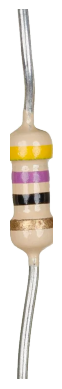

In [10]:
# No white example
image_path = 'RESISTORS_1_no_white.png' 
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  
plt.show()

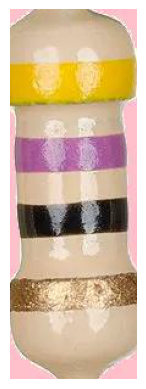

In [11]:
# Remove all almost transparent part
# Make all transparent pink, because HSV cannot read the transparent part, it will read it as white
image_path = 'RESISTORS_1_transparent_horizontal.jpg' 
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  
plt.show()

## Colour processing

In [12]:
# Self_defined color boundaries (the public one does not apply here)
color_boundaries = {
    'black': ([0, 0, 0], [180, 255, 70]),
    'brown': ([1, 100, 100], [12, 255, 170]),
    'red': ([80, 150, 100], [200, 255, 255]),
    'orange': ([5, 100, 160], [15, 255, 255]),
    'yellow': ([17, 100, 180], [25, 255, 255]),
    'green': ([35, 100, 0], [85, 255, 255]),
    'blue': ([85, 100, 100], [135, 255, 255]),
    'violet': ([100, 80, 80], [160, 255, 255]),
    # 'grey': ([0, 0, 40], [180, 50, 80]), 
    'white': ([0, 0, 200], [180, 20, 255]),
    'gold': ([12, 100, 100], [20, 200, 240]), #没问题
    # 'gold': ([11, 60, 100], [30, 255, 180]),
    # 'silver': ([0, 0, 50], [180, 15, 255]) 
}

In [13]:
# Change the original to HSV List in pixels
def get_hsv_list(image_path, num_lines=5):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    def extract_hsv_values(hsv_image, line_position):
        return hsv_image[:, line_position, :]

    width = hsv.shape[1]
    line_positions = [width * i // num_lines for i in range(num_lines)]
    hsv_lists = []

    for position in line_positions:
        hsv_values = extract_hsv_values(hsv, position)
        hsv_list = [tuple(hsv_values[i]) for i in range(hsv_values.shape[0])]
        hsv_lists.append(hsv_list)
    return hsv_lists
# Identify the color of each part (sub function of next function below)
def identify_color(hsv_value, color_boundaries):
    for color, (lower, upper) in color_boundaries.items():
        if all(lower[i] <= hsv_value[i] <= upper[i] for i in range(3)):
            return color
    return 'undefined'
# Covert HSV list to colour ( We use three lists to make sure they are the same) 
def hsv_lists_to_colour(hsv_list1, hsv_list2, hsv_list3):
    color_names = []
    # If three columns pixels, two of them are the same, then return this colour
    # If they are the same, but they are undefined, ignore this part. 
    for hsv1, hsv2, hsv3 in zip(hsv_list1, hsv_list2, hsv_list3):
        color1 = identify_color(hsv1, color_boundaries)
        color2 = identify_color(hsv2, color_boundaries)
        color3 = identify_color(hsv3, color_boundaries)
        if color1 == color2 or color1 == color3 or color2 == color3:
            if color1 != 'undefined':
                color_names.append(color1)
            elif color2 != 'undefined':
                color_names.append(color2)
            elif color3 != 'undefined':
                color_names.append(color3)
    return color_names

def colour_filters(colors):
    # Sub function used for testing
    def convert_list_to_format(lst):
        """
        Convert a list of elements into a formatted string
        Input: [1,1,1,2,2,2,3,3,2,3,3,2,3,1]
        Output: '1: 3 elements  2: 3 elements 3: 2 elements ... and so on
        """
        formatted_output = []
        count = 1
    
        for i in range(1, len(lst)):
            if lst[i] == lst[i-1]:
                count += 1
            else:
                formatted_output.append(f"{lst[i-1]}: {count} elements")
                count = 1
    
        # Add the last element
        formatted_output.append(f"{lst[-1]}: {count} elements")
    
        return '\n'.join(formatted_output)

    # print(convert_list_to_format(colors)) # Used to print testing results
    color_counts = Counter(colors)
    # If colour counts are smaller than 2, it will not be considered as one of the top colours
    # The maximum number of top colours would be 4. It might be 3 or 2. 
    top_colors = [color for color, count in color_counts.most_common(4) if count > 2]
    # print(top_colors)
    # Filter this only keep the top colours
    filtered_colors = []
    for color in colors:
        if color in top_colors:
            filtered_colors.append(color)
    return filtered_colors
# Use the above new list to generate the final colour list
def extract_unique_colors(color_list):
    def remove_elements_with_few_occurrences(lst):
        if not lst: 
            return []
    
        new_list = []
        count = 1 
        prev_element = lst[0]
    
        for element in lst[1:] + [None]: 
            if element == prev_element:
                count += 1 
            else:
                if count > 2: 
                    new_list.extend([prev_element] * count)  
                count = 1  
            prev_element = element
    
        return new_list
    # Remove the colours only appear 2 times
    # We here filter it again is because although they are already the top colours, they may still have similarities 
    # due to the light reflection, eg. yellow and orange/gold
    # So we filter again
    color_list = remove_elements_with_few_occurrences(color_list)
    uniq = []
    times_l = []
    curr = color_list[0]
    times = 0
    # Append uniq colours to the list (uniq allows repeat here, like: orange white orange, is allowed)
    for i in color_list:
        if i == curr:
            times+=1
        else:
            uniq.append(curr)
            times_l.append(times)
            curr = i
            times = 1
    # append the last one after the loop
    uniq.append(curr)
    times_l.append(times)
    def find_max_position(lst):
        max_value = max(lst)
        max_position = lst.index(max_value)
        return max_position
    def closest_number(target):
        num1 = 1/3
        num2 = 1
        num3 = 3
        diff1 = abs(target - num1)
        diff2 = abs(target - num2)
        diff3 = abs(target - num3)
        min_diff = min(diff1, diff2, diff3)
        if min_diff == diff1:
            return 1
        elif min_diff == diff2:
            return 2
        else:
            return 3
    # If there are only 4 unique numbers, meaning that YEAAA, they are the colours!!!
    if len(uniq) == 4: 
        return uniq
    # If there are only 3 unique numbers, we realize that there may be one more colour duplicate! 
    # Find the most count of the colour, and double it
    elif len(uniq)==3:
        pos = find_max_position(times_l)
        color = uniq[pos]
        uniq.insert(pos,color)
        return uniq
    # If two colours in the list, see their ratios
    # If each of them are 1/2 of the count, then easy, 2 of each
    # If each of them are 1/3 and 2/3, then 3 colour1 and 1 colour2
    # Other wise 3 colour2 1 colour1 and insert them to the corresponding location
    elif len(uniq) == 2:   
        ratio = float(times_l[0])/float(times_l[1])
        close_number = closest_number(ratio)
        if close_number == 1:
            uniq.insert(-1,uniq[-1])
            uniq.insert(-1,uniq[-1])
        elif close_number == 2:
            uniq.insert(0, uniq[0])
            uniq.insert(-1, uniq[-1])
        elif close_number == 3:
            uniq.insert(0, uniq[0])
            uniq.insert(0, uniq[0])
        return uniq
    elif len(uniq) == 1:
        uniq.insert(0,uniq[0])
        uniq.insert(0,uniq[0])
        uniq.insert(0,uniq[0])
        return uniq
    else:
        return uniq[:4]

In [14]:
# Final run the functions
bands = []
for i in range(len(resistor_imgs)):
    image_path = f'RESISTORS_{i}_transparent_horizontal.jpg'
    hsv_list = get_hsv_list(image_path)
    color_names = hsv_lists_to_colour(hsv_list[1],hsv_list[2],hsv_list[3])
    filtered_colors = colour_filters(color_names)
    bands.append(extract_unique_colors(filtered_colors))
bands

[['gold', 'orange', 'white', 'orange'],
 ['yellow', 'violet', 'black', 'gold'],
 ['brown', 'green', 'red', 'gold'],
 ['orange', 'brown', 'black', 'brown'],
 ['gold', 'red', 'red', 'red'],
 ['yellow', 'violet', 'orange', 'gold']]

In [15]:
def calculate_resistance(bands):
    # Calculate resistance value, which is the easiest part here. 
    # Color code
    color_codes = {
        'black': 0, 'brown': 1, 'red': 2, 'orange': 3, 'yellow': 4,
        'green': 5, 'blue': 6, 'violet': 7, 'gray': 8, 'white': 9
    }
    # Tolerance
    tolerance_codes = {
        'brown': 1, 'red': 2, 'green': 0.5, 'blue': 0.25,
        'violet': 0.1, 'gray': 0.05, 'gold': 5, 'silver': 10
    }
    # Check if reverse order 
    if bands[0] in ['gold', 'silver']:
        bands = bands[::-1]  # Reverse the list
    # Calculate the resistance value
    try:
        resistance = (color_codes[bands[0]] * 10 + color_codes[bands[1]]) * (10 ** color_codes[bands[2]])
        tolerance = tolerance_codes[bands[3]]
        return resistance, tolerance
    except KeyError:
        # Return an error message if an invalid color is provided
        return "Invalid color code in the bands"

In [16]:
for i in range(len(bands)):
    print(bands[i])
    print(calculate_resistance(bands[i]))

['gold', 'orange', 'white', 'orange']
(39000, 5)
['yellow', 'violet', 'black', 'gold']
(47, 5)
['brown', 'green', 'red', 'gold']
(1500, 5)
['orange', 'brown', 'black', 'brown']
(31, 1)
['gold', 'red', 'red', 'red']
(2200, 5)
['yellow', 'violet', 'orange', 'gold']
(47000, 5)
